# Passbands Tutorial
This tutorial shows how to create and use passband objects with response functions that can be (1) tabulated from files, or (2) have top-hat shapes.

Let's start by importing some necessary modules:

In [1]:
import pyratbay.io as io
import pyratbay.spectrum as ps
import pyratbay.constants as pc

import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=20, precision=4)

## 1. Passband objects
### 1.1 Passband from tabulated file

In [2]:
# Passband objects can be created reading from a file
# that tabulates the wavelength and response function:
filter_file = f'{pc.ROOT}pyratbay/data/filters/spitzer_irac2_sa.dat'
band = ps.PassBand(filter_file)

In [3]:
# This is some useful data contained in the object:
print(f'Filter name: {band.name}')
print(f'Central wavelength: {band.wl0:.3f} um\n')

print(f'Filter file: {band.filter_file}\n')
print(f'Wavelength array (um): {band.wl}')
print(f'Wavenumber array (cm-1): {band.wn}')
print(f'Response function: {band.response}')

Filter name: spitzer_irac2_sa
Central wavelength: 4.471 um

Filter file: /Users/pato/Dropbox/IWF/projects/2014_pyratbay/pyratbay/pyratbay/data/filters/spitzer_irac2_sa.dat

Wavelength array (um): [5.222  5.2167 5.2115 ... 3.7278 3.7252 3.7225]
Wavenumber array (cm-1): [1914.9824 1916.9133 1918.8407 ... 2682.5186 2684.4485 2686.3739]
Response function: [0.0004 0.0004 0.0004 ... 0.0007 0.0007 0.0008]


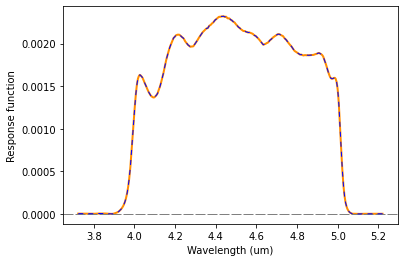

In [4]:
# Evaluate passband over a specific wavelength array (um):
wl = np.arange(3.5, 5.5, 0.001)
out_wl, out_response = band(wl)

# Show profile:
plt.figure(1)
plt.clf()
plt.plot(out_wl, out_response, color='darkorange', lw=2.0)
plt.axhline(0.0, color='gray', lw=1.0, dashes=(10,2))
plt.xlabel('Wavelength (um)')
plt.ylabel('Response function')
# Note that returned values are the same as the internal variables:
# out_wl = band.wl
# out_response = band.response

# The variable band.idx points to the indices in input wl
# that overlap with the band's wavelength:
# (Note wl differs from band.wl)
plt.plot(wl[band.idx], band.response, color='blue', lw=1.0, dashes=(5,5))

In [5]:
# The band response function is scaled such that the
# integral over wavenumber equals one:
band_integral = np.trapz(band.response, band.wn)
print(f'Integral of response function: {band_integral:.3f}')

Integral of response function: 1.000


Text(0, 0.5, 'Response function')

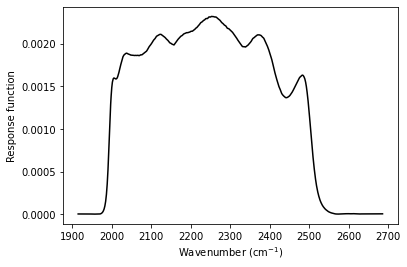

In [6]:
# It is possible to evaluate the passband over a wavenumber array:
wn = 1e4 / wl
out_wn, out_response = band(wn=wn)

plt.figure(1)
plt.clf()
plt.plot(band.wn, band.response, color='black')
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Response function')

### 1.2 Top-hat passband

In [7]:
# Top-hat passband objects can be created by setting
# their central wavelength and half-width (in micron units):
wl0 = 4.5
half_width = 0.5
band = ps.Tophat(wl0, half_width)

Text(0, 0.5, 'Response function')

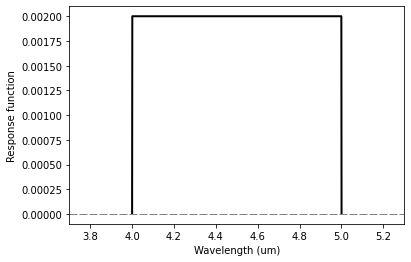

In [8]:
# Evaluate passband over a specific wavelength array (um):
wl = np.arange(3.5, 5.5, 0.001)
out_wl, out_response = band(wl)

# Show profile:
plt.figure(1)
plt.clf()
plt.plot(out_wl, out_response, color='black', lw=2.0)
plt.xlim(3.7, 5.3)
plt.axhline(0.0, color='gray', lw=1.0, dashes=(8,2))
plt.xlabel('Wavelength (um)')
plt.ylabel('Response function')

In [9]:
# Same as with ps.Passband(), a tophat response function is scaled
# such that the integral over wavenumber equals one:
band_integral = np.trapz(band.response, band.wn)
print(f'Integral of response function: {band_integral:.3f}')

Integral of response function: 1.000


## 2. Create a set of passbands
If you have a set of observations for a given target, you can generate a set of filters for these data by loading the info from a file like the one below (not how you can combine top-hat and from filter files):

```bash
# observations.dat file

# Passband info could be (1) a path to a file or (2) a tophat filter
# defined by a central wavelength, half-width, and optionally a name

# Comment lines (like this one) and blank lines are ignored,
# central-wavelength and half-width units are always microns

# @DEPTH_UNITS sets the depth and uncert units (none, percent, ppt, ppm)
# and also indicates that there's data and uncerts to read
# as two columns before the passband info
@DEPTH_UNITS
ppm

@DATA
# depth uncert  wavelength half_width passband_name
# depth uncert  passband_file
    200    50   0.900    0.075
    214    82   1.148    0.046  HST_WFC3
    325    83   1.240    0.046  HST_WFC3
    415    82   1.332    0.046  HST_WFC3
    621    97   1.424    0.046  HST_WFC3
    765   101   1.516    0.046  HST_WFC3
    732   107   1.608    0.046  HST_WFC3
   1148    84   {ROOT}/pyratbay/data/filters/spitzer_irac1_sa.dat
   1275    92   {ROOT}/pyratbay/data/filters/spitzer_irac2_sa.dat
```

In [10]:
# Load passbands and observations info:
obs_file = 'observations.dat'
bands, depths, uncerts = io.read_observations(obs_file)

# Evaluate pass band over a given spectral array:
wl = np.linspace(0.5, 5.5, 1000)
for band in bands:
    band(wl)


# Summary of data:
print('band              wl (um)  depth (ppm)')
for i,band in enumerate(bands):
    depth = depths[i] / pc.ppm
    err = uncerts[i] / pc.ppm
    print(f'{band.name:16s}  {band.wl0:.2f}  {depth:9.1f} +/- {err:5.1f}')

band              wl (um)  depth (ppm)
tophat            0.90      200.0 +/-  50.0
HST_WFC3          1.15      214.0 +/-  82.0
HST_WFC3          1.24      325.0 +/-  83.0
HST_WFC3          1.33      415.0 +/-  82.0
HST_WFC3          1.42      621.0 +/-  97.0
HST_WFC3          1.52      765.0 +/- 101.0
HST_WFC3          1.61      732.0 +/- 107.0
spitzer_irac1_sa  3.52     1148.0 +/-  84.0
spitzer_irac2_sa  4.47     1275.0 +/-  92.0


Text(0, 0.5, 'Eclipse depth (ppm)')

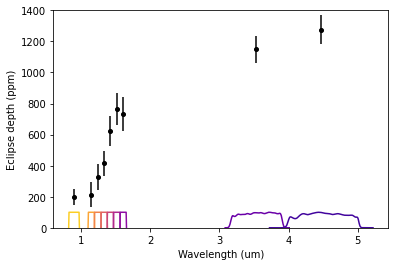

In [11]:
# Plot the data and passbands:
nbands = len(bands)
colors = [plt.cm.plasma_r(0.1 + 0.1*i) for i in range(nbands)]
bands_wl = [band.wl0 for band in bands]

plt.figure(10)
plt.clf()
plt.errorbar(bands_wl, depths/pc.ppm, uncerts/pc.ppm, fmt='ok', ms=4.0)
for i,band in enumerate(bands):
    response = band.response / np.amax(band.response) * 100
    plt.plot(band.wl, response, color=colors[i])

plt.ylim(0, 1400)
plt.xlabel('Wavelength (um)')
plt.ylabel('Eclipse depth (ppm)')